In [1]:
import blosc2
import numpy as np
import archetypes as arch

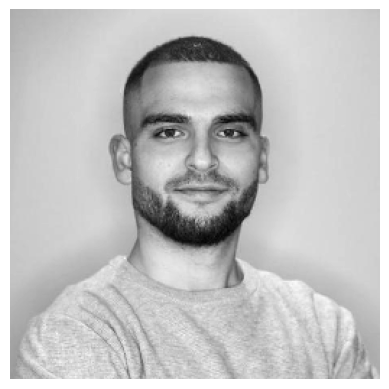

In [2]:
import cv2

img = cv2.imread("C:/Users/aalcacer/Projects/biaa-codec/profile.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC).astype(np.float64)

import matplotlib.pyplot as plt

plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()


In [3]:
# Create an User-defined codec (just a memcpy)

def encoderBiAA(input, output, meta, schunk: blosc2.SChunk):
    shape = (meta, meta)
    dtype = np.dtype(np.float64)
    itemsize = dtype.itemsize
    block_edge = int(np.sqrt(schunk.blocksize / itemsize))
    shape = (block_edge, block_edge)
    img = np.frombuffer(input[:schunk.blocksize], dtype=dtype).reshape(shape)

    # apply biaa
    model = arch.BiAA(n_archetypes=(3, 3), max_iter=1000, random_state=0, n_init=10, tol=1e-16)
    model.fit(img)

    # save archetypes
    archetypes = model.archetypes_
    alphas, gammas = model.transform(img)

    archetypes_shape = np.array(archetypes.shape, dtype=np.uint32)
    alphas_shape = np.array(alphas.shape, dtype=np.uint32)
    gammas_shape = np.array(gammas.shape, dtype=np.uint32)


    # Serialize archetypes info
    output_start = 0
    output_stop = archetypes_shape.nbytes
    output[output_start:output_stop] = archetypes_shape.view(np.uint8).reshape(-1)
    
    output_start = output_stop
    output_stop += archetypes.nbytes
    output[output_start:output_stop] = archetypes.view(np.uint8).reshape(-1)
    
    # Serialize alphas info
    output_start = output_stop
    output_stop += alphas_shape.nbytes
    output[output_start:output_stop] = alphas_shape.view(np.uint8).reshape(-1)

    output_start = output_stop
    output_stop += alphas.nbytes
    output[output_start:output_stop] = alphas.view(np.uint8).reshape(-1)

    # Serialize gammas info
    output_start = output_stop
    output_stop += gammas_shape.nbytes
    output[output_start:output_stop] = gammas_shape.view(np.uint8).reshape(-1)

    output_start = output_stop
    output_stop += gammas.nbytes
    output[output_start:output_stop] = gammas.view(np.uint8).reshape(-1)

    return output_stop

In [4]:
def decoderBiAA(input, output, meta, schunk: blosc2.SChunk):
    dtype = np.dtype(np.float64)
    itemsize = dtype.itemsize
    
    input_start = 0
    input_stop = 8
    archetypes_shape = np.frombuffer(input[input_start:input_stop], dtype=np.uint32)

    input_start = input_stop
    input_stop += archetypes_shape.prod() * itemsize
    archetypes = np.frombuffer(input[input_start:input_stop], dtype=dtype).reshape(archetypes_shape)

    input_start = input_stop
    input_stop += 8
    alphas_shape = np.frombuffer(input[input_start:input_stop], dtype=np.uint32)

    input_start = input_stop
    input_stop += alphas_shape.prod() * itemsize
    alphas = np.frombuffer(input[input_start:input_stop], dtype=dtype).reshape(alphas_shape)

    input_start = input_stop
    input_stop += 8
    gammas_shape = np.frombuffer(input[input_start:input_stop], dtype=np.uint32)

    input_start = input_stop
    input_stop += gammas_shape.prod() * itemsize
    gammas = np.frombuffer(input[input_start:input_stop], dtype=dtype).reshape(gammas_shape)

    img = alphas @ archetypes @ gammas
  
    output[:schunk.blocksize] = img.view(np.uint8).reshape(-1)

    return schunk.blocksize


In [5]:

# Register the codec
codec_id = 213
# blosc2.register_codec('BiAA', codec_id, encoderBiAA, decoderBiAA)

In [6]:
# Create an User-defined codec (just a memcpy)

def encoderAA(input, output, meta, schunk: blosc2.SChunk):
    dtype = np.dtype(np.float64)
    itemsize = dtype.itemsize
    block_size = int(np.sqrt(schunk.blocksize / itemsize))
    shape = (block_size, block_size)
    img = input.view(dtype=dtype).reshape(shape)

    # convert img to a 3D array with tiles of size 4x4
    tile_size = 4
    img = img.reshape((block_size//tile_size, tile_size, block_size//tile_size, tile_size))
    img = img.transpose((0, 2, 1, 3))
    img = img.reshape((block_size//tile_size, block_size//tile_size, tile_size*tile_size))
    img = img.reshape(-1, tile_size * tile_size)

    # apply aa
    model = arch.AA(n_archetypes=meta, max_iter=100, random_state=0, n_init=1)
    model.fit(img)

    # save archetypes
    archetypes = model.archetypes_
    alphas = model.transform(img)

    archetypes_shape = np.array(archetypes.shape, dtype=np.uint32)
    alphas_shape = np.array(alphas.shape, dtype=np.uint32)

    # Serialize archetypes info
    output_start = 0
    output_stop = archetypes_shape.nbytes
    output[output_start:output_stop] = archetypes_shape.view(np.uint8).reshape(-1)
    
    output_start = output_stop
    output_stop += archetypes.nbytes
    output[output_start:output_stop] = archetypes.view(np.uint8).reshape(-1)
    
    # Serialize alphas info
    output_start = output_stop
    output_stop += alphas_shape.nbytes
    output[output_start:output_stop] = alphas_shape.view(np.uint8).reshape(-1)

    output_start = output_stop
    output_stop += alphas.nbytes
    output[output_start:output_stop] = alphas.view(np.uint8).reshape(-1)

    return output_stop

In [7]:
def decoderAA(input, output, meta, schunk: blosc2.SChunk):
    tile_size = 4
    dtype = np.dtype(np.float64)
    itemsize = dtype.itemsize
    blockedge_size = int(np.sqrt(schunk.blocksize / itemsize))

    input_start = 0
    input_stop = 8
    archetypes_shape = input[input_start:input_stop].view(np.uint32)

    input_start = input_stop
    input_stop += archetypes_shape.prod() * itemsize
    archetypes = input[input_start:input_stop].view(dtype).reshape(archetypes_shape)

    input_start = input_stop
    input_stop += 8
    alphas_shape = input[input_start:input_stop].view(np.uint32)

    input_start = input_stop
    input_stop += alphas_shape.prod() * itemsize
    alphas = input[input_start:input_stop].view(dtype).reshape(alphas_shape)

    img = alphas @ archetypes
    
    img = img.reshape((blockedge_size//tile_size, blockedge_size//tile_size, tile_size, tile_size))
    img = img.transpose((0, 2, 1, 3))
    img = img.reshape((blockedge_size, blockedge_size))
  
    output[:schunk.blocksize] = img.view(np.uint8).reshape(-1)

    return schunk.blocksize


In [8]:
codec_id = 253
blosc2.register_codec('AA', codec_id, encoderAA, decoderAA)

2
3
4
5
6
7
8
9
10


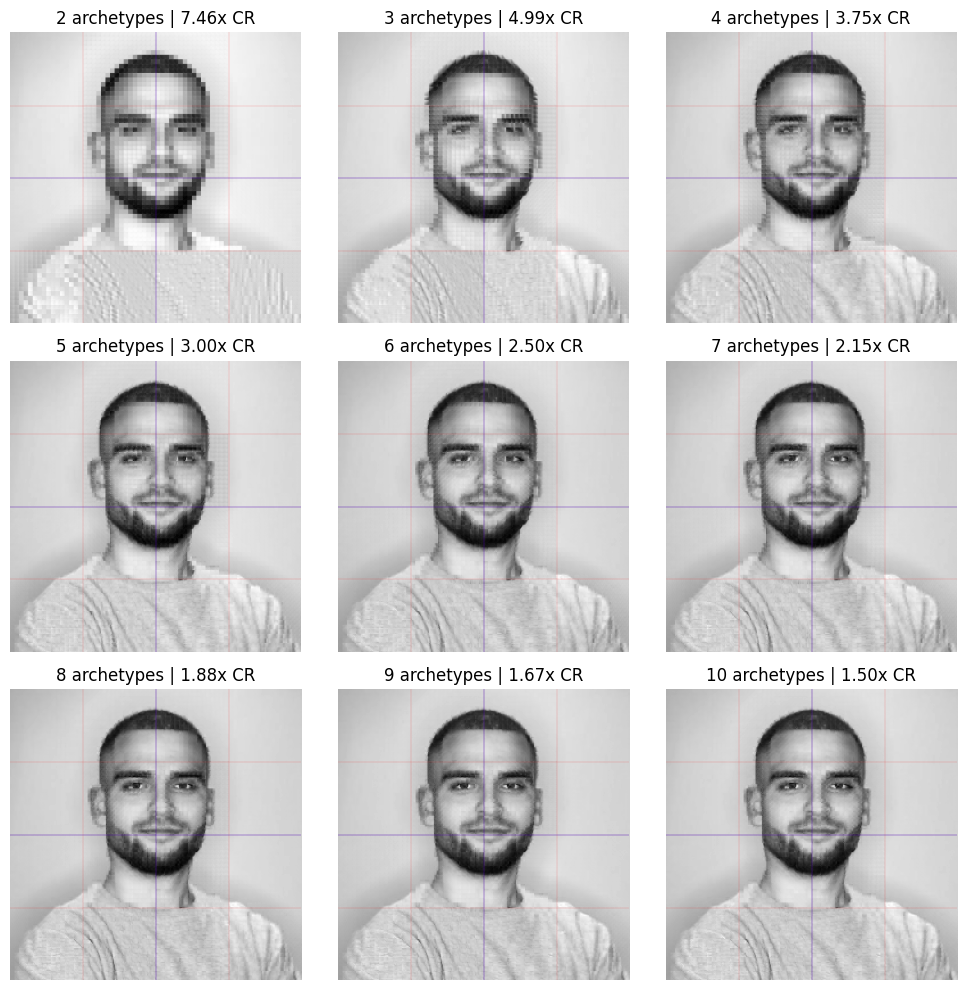

In [9]:

chunks = (128, 128)
blocks = (64, 64)

cparams = {
    'codec': codec_id,
    'codec_meta': 0,
    'nthreads': 1,
    'filters': [],
    'splitmode': blosc2.SplitMode.NEVER_SPLIT,
}

dparams = {
    'nthreads': 1,
}

# Create a subplot with 2 rows and 3 columns
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

fax = ax.ravel()

for i in range(len(fax)):
    k = i + 2
    print(k)
    cparams['codec_meta'] = k
    c_img = blosc2.asarray(img, chunks=chunks, blocks=blocks, cparams=cparams, dparams=dparams)
    
    fax[i].imshow(c_img[:], cmap="gray")
    fax[i].axis('off')
    fax[i].set_title(f"{i+2} archetypes | {c_img.schunk.cratio:.2f}x CR")

    for j in range(blocks[0], img.shape[0], blocks[0]):
        fax[i].axhline(j, color='red', lw=.1)
    for j in range(blocks[1], img.shape[1], blocks[1]):
        fax[i].axvline(j, color='red', lw=.1)

    for j in range(chunks[0], img.shape[0], chunks[0]):
        fax[i].axhline(j, color='blue', lw=.2)
    for j in range(chunks[1], img.shape[1], chunks[1]):
        fax[i].axvline(j, color='blue', lw=.2)

plt.tight_layout()
plt.show()

In [10]:
50*50*4

10000